In [1]:
# setup library imports
import pandas as pd
import re
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('ggplot')
# AUTOLAB_IGNORE_START
%matplotlib inline
# AUTOLAB_IGNORE_STOP
import scipy as sp
from scipy import special
import scipy.stats as stats
from datetime import datetime

# Introduction

In this project, we will analyze the popularity of YouTube videos. We define the popularity of YouTube videos by total view counts. Our goal is to determine the correlations between video popularity and various video attributes. Also, we will use these features to predict video popularity and analyze the real-life implication of the results.

# Table of Contents

* [Data Collection](#section_One)
* [Data Processing & Visualization](#section_Two)
* [Feature Selection](#section_Three)
* [Prediction Results](#section_Four)
* [Conclusion](#section_Five)
* [References](#section_Six)

<a id="section_One"></a>
# Data Collection

We utilize [YoutTube Data API v3](https://developers.google.com/youtube/v3/getting-started) to collect information needed to perform our analysis. For analysis purpose, we restricted data to videos with region code set as the United States. Below is the steps we went through for collecting data:

- Search for videos with region code 'US'. 
- For each retrieved video, search the channel information and detailed video information by establishing separate queries. 

In [2]:
from apiclient.discovery import build
from apiclient.errors import HttpError
from oauth2client.tools import argparser
import pandas as pd
import pprint 
import matplotlib.pyplot as pd
import pprint
from pandas.io.json import json_normalize 

pp = pprint.PrettyPrinter(indent=4)


# Information needed to setup authentication to use YouTube API. 
DEVELOPER_KEY = "this is your YouTube API KEY"
YOUTUBE_API_SERVICE_NAME = "youtube"
YOUTUBE_API_VERSION = "v3"


"""
This function performs the "search" step for videos with region code 'US'. 

Args:
    max_results (int): The max results a single search query returns (parameter passed to Youtube API). 
                       Default is 50. 
    order (string): Parameter passed to API to specify the search result return order. 
                    Default is relevance which means result videos are sorted by how relevant they are to our query. 
    token (string): Since the search results may be too large to return at once, they are saprated into pages. 
                    One page is returned every time. token is used to inform which page we are asking for. 
                    Default is None and would get the first page. 

Returns:
    next_page (string): page token which refers to next page
    df (pandas.DataFrame): dataframe containing videos as the row with columns indicating information of the videos
"""
def youtube_fectchUS(max_results=50,order="relevance", token=None, location=None,
                     location_radius=None, query_term=None):

    youtube = build(YOUTUBE_API_SERVICE_NAME, YOUTUBE_API_VERSION,developerKey=DEVELOPER_KEY)

    search_response = youtube.search().list(
    q=query_term,
    type="video",
    pageToken=token,
    order = order,
    part="id,snippet",
    maxResults=max_results,
    location=location,
    locationRadius=location_radius, 
    regionCode='US').execute()

    next_page = search_response.get("nextPageToken")
    
    result = search_response.get("items", [])
    
    df = json_normalize(result)
    return next_page, df

"""
This function helps to retrievce channel related information. 

Args:
    id (string): Youtube channel ID (retrieved using previous youtube_fectchUS function). 
    
Returns:
    channel_info (json): Youtube API json result for channel information. 
"""
def channel_info(id):
    
    youtube = build(YOUTUBE_API_SERVICE_NAME, YOUTUBE_API_VERSION,developerKey=DEVELOPER_KEY)
    
    channel_info = youtube.channels().list(
        
        part='snippet,contentDetails,statistics',
        id=id
    ).execute()
    
    return channel_info

"""
This function helps to retrieve more detailed information of video. 

Args:
    id (string): Youtube video ID (retrieved using previous youtube_fectchUS function). 
    
Returns:
    video_info (json): Youtube API json result for video information. 
"""
def video_info(id):
    
    youtube = build(YOUTUBE_API_SERVICE_NAME, YOUTUBE_API_VERSION,developerKey=DEVELOPER_KEY)
    
    video_info = youtube.videos().list(
                    
        part='statistics, contentDetails,snippet',
        id=id
    ).execute()
    
    return video_info

We fetch search result page by page and append the dataframes together. The search result could return entries other than video so we perform filtering on 'kind' to make sure all entries is desired results.

In [3]:
cur_page = None
df_list = []
# Here, the query term is "a" for display purposes. 
q_list = ['a']
for j in q_list:
    next_page, df = youtube_fectchUS(query_term = j, token = cur_page)
    df_list.append(df)
    cur_page = next_page
    while cur_page is not None:
        next_page, df = youtube_fectchUS(query_term = j, token = cur_page)
        df_list.append(df)
        cur_page = next_page

df = df_list[0]

for cur_df in df_list[1:]:
    
    df = df.append(cur_df, ignore_index=True)
    
df = df.loc[df['id.kind'] == 'youtube#video']

print(df['etag'].count())
print(df.head(5))

356
                                                etag        id.kind  \
0  "95M1zlW0txkV42I4OG1Zscxrg5A/L0GzIMNHW11RstSRa...  youtube#video   
1  "95M1zlW0txkV42I4OG1Zscxrg5A/hV5gq7R8vy2iOSs_i...  youtube#video   
2  "95M1zlW0txkV42I4OG1Zscxrg5A/PYUayVh6hBol2xJip...  youtube#video   
3  "95M1zlW0txkV42I4OG1Zscxrg5A/SP-JetN-x3KWocnKT...  youtube#video   
4  "95M1zlW0txkV42I4OG1Zscxrg5A/gnnoL97DCc0rABuCC...  youtube#video   

    id.videoId                  kind         snippet.channelId  \
0  q2sI-T69sjs  youtube#searchResult  UCqFzWxSCi39LnW1JKFR3efg   
1  2KRTYMxPWJw  youtube#searchResult  UCiWLfSweyRNmLpgEHekhoAg   
2  astISOttCQ0  youtube#searchResult  UCLoKWb_rlp80mg0aSLtsUGw   
3  -RP19fnff_c  youtube#searchResult  UCWEtnEiVwUy7mwFeshyAWLA   
4  3bUSA5HNjX8  youtube#searchResult  UCMc_udNCbogsweA2o58knww   

  snippet.channelTitle                                snippet.description  \
0  Saturday Night Live  Friends (Donald Glover, Cecily Strong, Kenan T...   
1                 

For each video retrieved, we fetched their channel information using the channel IDs.

In [4]:
channelid_list  = df['snippet.channelId']
channel_info_list = channelid_list.apply(channel_info)
channel_df = json_normalize(list(channel_info_list))

channelViewCount = channel_df['items'].apply(lambda x: x[0]['statistics']['viewCount']
                                             if len(x) != 0 and len(x[0]) !=0 else None)
channelCommentCount = channel_df['items'].apply(lambda x: x[0]['statistics']['commentCount']
                                               if len(x) != 0 and len(x[0]) !=0 else None)
channelSubscribe = channel_df['items'].apply(lambda x: x[0]['statistics']['subscriberCount']
                                            if len(x) != 0 and len(x[0]) !=0 else None)
channelVideo = channel_df['items'].apply(lambda x: x[0]['statistics']['videoCount']
                                        if len(x) != 0 and len(x[0]) !=0 else None)

final_df = df.assign(channel_viewcount = channelViewCount)
final_df = final_df.assign(channel_commentcount = channelCommentCount)
final_df = final_df.assign(channel_subscribe = channelSubscribe)
final_df = final_df.assign(channel_videocount = channelVideo)

Then, to obtain more detailed information for each video, we asked for video lists based on the video IDs.

In [5]:
videoid_list = df['id.videoId']
video_info_list = videoid_list.apply(video_info)
video_df = json_normalize(list(video_info_list))

videoCommentCount = video_df['items'].apply(
    lambda x: x[0]['statistics']['commentCount'] if len(x) != 0 and len(x[0]) !=0 and
    'commentCount' in x[0]['statistics'].keys() else None)
videoDislikeCount = video_df['items'].apply(
    lambda x: x[0]['statistics']['dislikeCount'] if len(x) != 0 and len(x[0]) !=0 and
    'dislikeCount' in x[0]['statistics'].keys() else None)
videoFavoriteCount = video_df['items'].apply(
    lambda x: x[0]['statistics']['favoriteCount'] if len(x) != 0 and len(x[0]) !=0 and
    'favoriteCount' in x[0]['statistics'].keys() else None)
videoLikeCount = video_df['items'].apply(
    lambda x: x[0]['statistics']['likeCount'] if len(x) != 0 and len(x[0]) !=0 and
    'likeCount' in x[0]['statistics'].keys() else None)
videoViewCount = video_df['items'].apply(
    lambda x: x[0]['statistics']['viewCount'] if len(x) != 0 and len(x[0]) !=0 and
    'viewCount' in x[0]['statistics'].keys() else None)
videoTags = video_df['items'].apply(
    lambda x: x[0]['snippet']['tags'] if len(x) != 0 and len(x[0]) !=0 and
    'tags' in x[0]['snippet'].keys() else None)
videoCategory = video_df['items'].apply(
    lambda x: x[0]['snippet']['categoryId'] if len(x) != 0 and len(x[0]) !=0 and
    'categoryId' in x[0]['snippet'].keys() else None)
videoDef = video_df['items'].apply(
    lambda x: x[0]['contentDetails']['definition'] if len(x) != 0 and len(x[0]) !=0 and
    'definition' in x[0]['contentDetails'].keys() else None)
videoDuration = video_df['items'].apply(
    lambda x: x[0]['contentDetails']['duration'] if len(x) != 0 and len(x[0]) !=0 and
    'duration' in x[0]['contentDetails'].keys() else None)

final_df = final_df.assign(video_commentCount = videoCommentCount)
final_df = final_df.assign(video_dislikeCount = videoDislikeCount)
final_df = final_df.assign(video_favoriteCount = videoFavoriteCount)
final_df = final_df.assign(video_likeCount = videoLikeCount)
final_df = final_df.assign(video_tags = videoTags)
final_df = final_df.assign(video_categoryId = videoCategory)
final_df = final_df.assign(video_def = videoDef)
final_df = final_df.assign(video_duration = videoDuration)
final_df = final_df.assign(video_viewCount = videoViewCount)

final_df.columns = [c.replace('_', '.') for c in final_df.columns]
print(final_df.columns.values)
print(final_df.head(5))

['etag' 'id.kind' 'id.videoId' 'kind' 'snippet.channelId'
 'snippet.channelTitle' 'snippet.description'
 'snippet.liveBroadcastContent' 'snippet.publishedAt'
 'snippet.thumbnails.default.height' 'snippet.thumbnails.default.url'
 'snippet.thumbnails.default.width' 'snippet.thumbnails.high.height'
 'snippet.thumbnails.high.url' 'snippet.thumbnails.high.width'
 'snippet.thumbnails.medium.height' 'snippet.thumbnails.medium.url'
 'snippet.thumbnails.medium.width' 'snippet.title' 'channel.viewcount'
 'channel.commentcount' 'channel.subscribe' 'channel.videocount'
 'video.commentCount' 'video.dislikeCount' 'video.favoriteCount'
 'video.likeCount' 'video.tags' 'video.categoryId' 'video.def'
 'video.duration' 'video.viewCount']
                                                etag        id.kind  \
0  "95M1zlW0txkV42I4OG1Zscxrg5A/L0GzIMNHW11RstSRa...  youtube#video   
1  "95M1zlW0txkV42I4OG1Zscxrg5A/hV5gq7R8vy2iOSs_i...  youtube#video   
2  "95M1zlW0txkV42I4OG1Zscxrg5A/PYUayVh6hBol2xJip...  yout

We go through this process for each page of our query results until we reach the last page and finally, we save the results to a csv file.

In [6]:
print(cur_page)
final_df.to_csv('finaldata_test.csv')

None


<a id="section_Two"></a>
# Data Processing & Visualization

Here, we are going to process the collected data before visualizing each feature of YouTube videos.

Firstly, we load data from .CSV file into dateframe. Our data processing consists of three parts: data cleaning, data reduction, and data transformation. For the data cleaning part, we fill in missing values with NaN and drop records with NaN values. For data reduction, we drop duplicates and get a cleaned dataframe with 10144 unique records, each with 32 features.

In [13]:
df = pd.read_csv('final_data.csv', encoding = 'latin1', index_col=0)
df = df.replace('', np.nan)
df = df.dropna(how='any')
df = df.drop_duplicates('id.videoId')
print(df.shape)
print(df.columns.values)

(10144, 32)
['etag' 'id.kind' 'id.videoId' 'kind' 'snippet.channelId'
 'snippet.channelTitle' 'snippet.description'
 'snippet.liveBroadcastContent' 'snippet.publishedAt'
 'snippet.thumbnails.default.height' 'snippet.thumbnails.default.url'
 'snippet.thumbnails.default.width' 'snippet.thumbnails.high.height'
 'snippet.thumbnails.high.url' 'snippet.thumbnails.high.width'
 'snippet.thumbnails.medium.height' 'snippet.thumbnails.medium.url'
 'snippet.thumbnails.medium.width' 'snippet.title' 'channel.viewcount'
 'channel.commentcount' 'channel.subscribe' 'channel.videocount'
 'video.commentCount' 'video.dislikeCount' 'video.favoriteCount'
 'video.likeCount' 'video.tags' 'video.categoryId' 'video.def'
 'video.duration' 'video.viewCount']


## Data Processing Methods

We perform the following data transformations on both the target and feature variables:
- series_tologit: normalize features, then process the features by logit, replace (positive and negative) infinity with NaN plot a histogram of features after dropping NaN.
- series_probplot: plot a histogram of features after processing z-normalization.

In [79]:
"""
This function takes in a series representing a feature and then convert it using logit function. 
It keeps NaN values for future processing purpose (straightly dropping these entries would result
in mismatch for dataframe)
"""

def series_tologit(feature):
    
    feature = (feature - feature.min()) / (feature.max() - feature.min())
    logit_f = special.logit(feature)
    logit_f = logit_f.replace([np.inf, -np.inf], np.nan)
    plt.hist(logit_f.dropna(), bins=50)
    plt.show()
    
    return logit_f

def series_probplot(feature):
    
    stats.probplot((feature - np.mean(feature))/np.std(feature),plot=plt)
    plt.show()

## Target Variable for Prediction

### Video View Count

We use view count as the measure for video popularity. Three possible candidates to represent popularity are: like count, dislike count and view count. Among these, we choose view count since like and dislike count are proportional to total view counts. After we processed the view count data, it fits the normal distribution and is ideal for our following feature analysis.

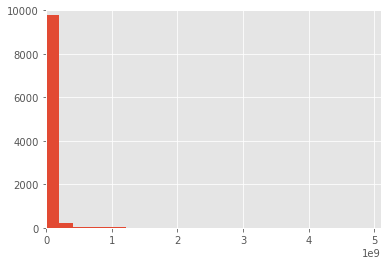

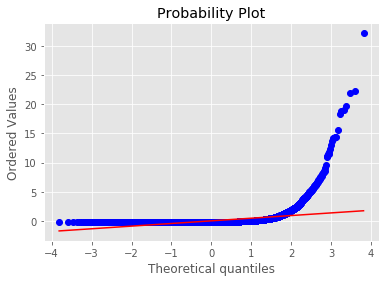

In [15]:
plt.hist(df['video.viewCount'], bins=25)
plt.axis([0, np.max(df['video.viewCount']), 0, 10000])
plt.show()
series_probplot(df['video.viewCount'])

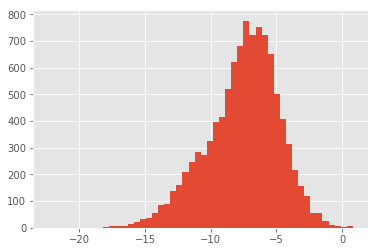

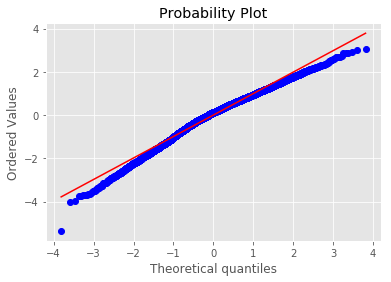

In [16]:
logit_video_viewcount = series_tologit(df['video.viewCount'])
series_probplot(logit_video_viewcount.dropna())

## Feature Analysis Method

We will use the random forest regression model to analyze the features. Random Forest is a supervised learning algorithm. It forms multiple decision trees and merges all the decision trees together to get a more accurate and stable prediction. The randomness means that this algorithm searches for the best feature among a random subset of features when developing the decision trees. This process creates a wider diversity and generally results a more accurate model for prediction. For this reason, we will perform the random forest regression on all of the 13 features.

We will evaluate the R² score of the cross validation results for the 13 features to make an initial analysis on which feature might be more important for the prediction. The formula for R² score is as follows:

\begin{equation*}
R^2(y, \hat{y}) = 1-\frac{\sum_{i=0}^{n_{samples}-1}({y_i-\hat{y_i}})^2}{\sum_{i=0}^{n_{samples}-1}({y_i-\bar{y}})^2}
\end{equation*}

${y}_i$ refers to the true value of the i-th sample <br>
$\hat{y}_i$ refers to the predicted value of the i-th sample <br>
$\bar{y}$ refers to the expected value of y

R² score provides a measure of how well future samples are likely to be predicted by the model. The best possible score is 1.0 and it can be negative. If the R² score is larger than 0.0, this means the model performs better than the baseline of using the expected value of y for prediction.

The following function will be used to perform the random forest regressor and evaluate the R² score for each feature.

In [73]:
from sklearn.cross_validation import cross_val_score, ShuffleSplit
from sklearn.ensemble import RandomForestRegressor

"""
This function takes in a feature array that contains all feature,
a target_array than contains video view count and the name for this feature.
It returns the r2 score for cross validation and the name of the feature. 
"""

def rfr_per_feature(feature_array, target_array, name = None):
    
    col_list = [feature_array, target_array]
    new_df = pd.concat(col_list, axis=1)
    new_df = new_df.dropna()
    feature = new_df.drop(['video.viewCount'], axis=1)
    target = new_df['video.viewCount']
    rf = RandomForestRegressor(random_state=1, n_estimators=20, max_depth=4)
    score = cross_val_score(rf, feature, target, scoring='r2', cv=ShuffleSplit(len(feature), 10, .1))
    print((round(np.mean(score), 3), name))

## Feature Variable for Prediction (13 features in total)

### Video Duration

In this section, we will analyze the correlation of video duration and the popularity of videos. First, we start from processing the raw data of video length. The original video length value is an ISO 8601 duration and we use the following function to convert it into seconds.

Then we process the data to get the logit representation of the video duration feature.

In [20]:
duration_list = []
for each_duration in df['video.duration']:
    duration_list.append(durationToSeconds(each_duration))
df['video.lengthInSec'] = duration_list

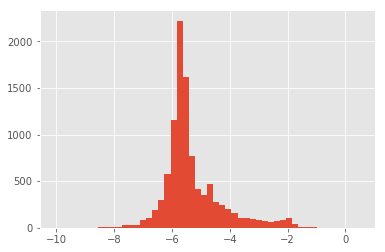

In [21]:
logit_video_duration = series_tologit(df['video.lengthInSec'])

Finally, we use the random forest regressor to view the R² score for video duration. The score is larger than zero, which means there are some correlation between total view counts and video length. As we can see from the plot, video view counts are larger when the video duration is shorter.

(0.20999999999999999, 'video duration')


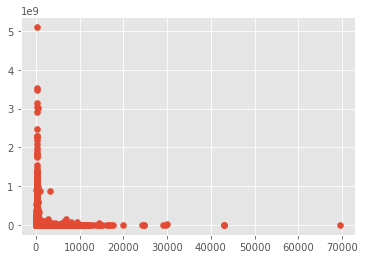

In [22]:
rfr_per_feature(logit_video_duration, logit_video_viewcount, name="video duration")
plt.scatter(df['video.lengthInSec'], df['video.viewCount'])
plt.show()

### Video Number of Days Published

Here, we discuss when were the videos uploaded and the video days old to see how this feature will affect the total view count. First, we process the data and create the logit representation for video days old.

In [23]:
published_time = []
no_of_days_published = []
time_list = df["snippet.publishedAt"].tolist()
for each_time in time_list:
    published_time.append(datetime.strptime(each_time, "%Y-%m-%dT%H:%M:%S.%fZ"))
current_time = datetime.now()
for each_publish_time in published_time:
    no_of_days_published.append((datetime.now() - each_publish_time).days)
df['no_of_days_published'] = no_of_days_published

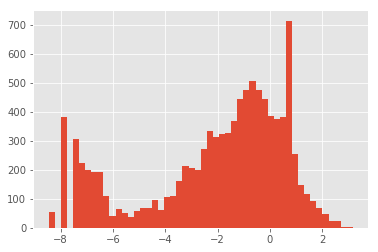

In [24]:
logit_video_days_old = series_tologit(df['no_of_days_published'])

Then we use the random forest regressor on this feature, the score is rather significant. This can also be proved from the following plot, which shows total view count will increase as number of days published increases.

(0.39000000000000001, 'video number of days published')


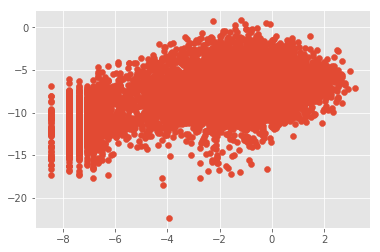

In [25]:
rfr_per_feature(logit_video_days_old, logit_video_viewcount, name="video number of days published")
plt.scatter(logit_video_days_old, logit_video_viewcount, alpha=1)
plt.show()

### Channel Viewcount

We suspect that the channel the video belongs to could also affect its view count. For instance, a video from a channel with more total view count would have higher view count.

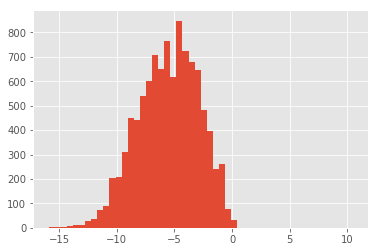

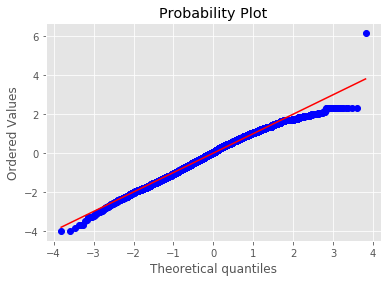

In [26]:
logit_channel_viewcount = series_tologit(df['channel.viewcount'])
series_probplot(logit_channel_viewcount.dropna())

The R² score of channel viewcount is relatively high among the features as you can see below. 

In [27]:
rfr_per_feature(logit_channel_viewcount, logit_video_viewcount, name="channel view count")

(0.23000000000000001, 'channel view count')


### Channel Subscribe

It is also possible if there are more people subscribe to a channel, more people would have chance to view videos under this channel. Therefore, we would like to investigate the relation between channel subscribe and video view count. 

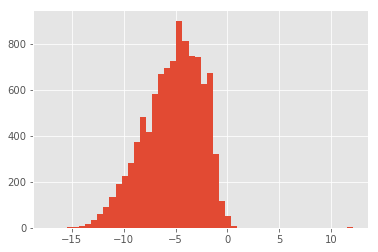

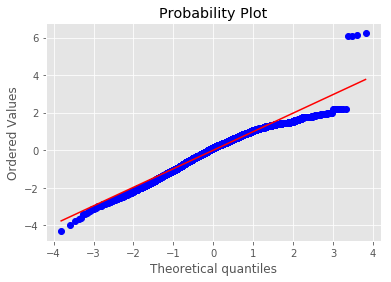

In [28]:
logit_channel_subscribe = series_tologit(df['channel.subscribe'])
series_probplot(logit_channel_subscribe.dropna())

The relevance seems not especially high comparing to other features but does show some correlation with video view count. 

In [29]:
rfr_per_feature(logit_channel_subscribe, logit_video_viewcount, name="channel subscribe")

(0.161, 'channel subscribe')


### Channel Video Count

Since a channel with more videos may have more chance to advertise its other video to the audiences, we take channel video count into consideration as well. 

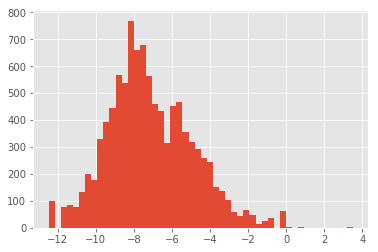

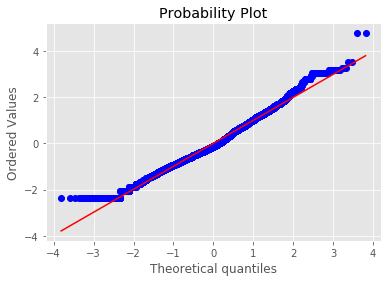

In [30]:
logit_channel_videocount = series_tologit(df['channel.videocount'])
series_probplot(logit_channel_videocount.dropna())

The relevance seems not especially high comparing to other features but does show some correlation with video view count.

In [31]:
rfr_per_feature(logit_channel_videocount, logit_video_viewcount, name="channel video count")

(0.13800000000000001, 'channel video count')


### Channel Comment Count

Comment count may also reflect the popularity of a channel so we also take this into account. 

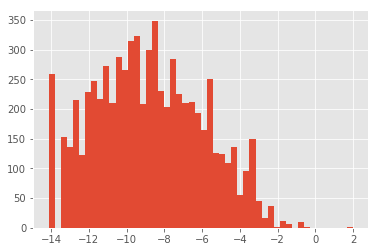

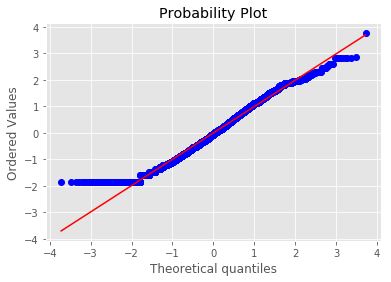

In [32]:
logit_channel_commentcount = series_tologit(df['channel.commentcount'])
series_probplot(logit_channel_commentcount.dropna())

The R² score of this feature however it especially low and seems not a good indicator for our target attribute. 

In [33]:
rfr_per_feature(logit_channel_commentcount, logit_video_viewcount, name="channel comment count")

(0.092999999999999999, 'channel comment count')


### Video Category ID

The category the video belongs to may also indicate its view count to some extent. Below is a figure showing the average view count for videos in each category. It is obvious there are some categories which shows very high average view count comparing to other categories. 

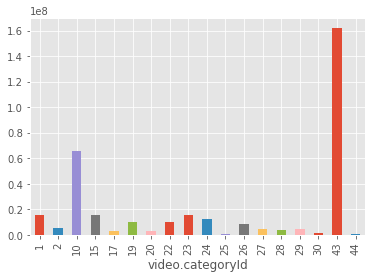

In [34]:
df.groupby('video.categoryId')['video.viewCount'].mean().plot('bar')
plt.show()

In [35]:
categoryID = pd.get_dummies(df['video.categoryId'])
new_name_list = ['categoryID.'+str(x) for x in categoryID.columns.values]
categoryID.columns = new_name_list

The R² score also demonstrate this could be a feature which reflects the popularity of the video. 

In [36]:
rfr_per_feature(categoryID, logit_video_viewcount, name="Video Category")

(0.26600000000000001, 'Video Category')


### Video Tags TFIDF

Every video contains some tags which give clues to its content. We use TFIDF to process video tags to create features. 

In [37]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(min_df=10, max_df=0.3, ngram_range=(1,3))

tag_tfidf = tfidf.fit_transform(df["video.tags"]).toarray()

Yet, the relevance for these features seem to be low and would not be good indicator. 

In [38]:
df_tfidf = pd.DataFrame(tag_tfidf)
rfr_per_feature(df_tfidf, logit_video_viewcount, name="Video Tags TFIDF")

(0.016, 'Video Tags TFIDF')


### Video Title Length

In this part, we will analyze whether the video title length will affect total view count of the video. We first process the data and count the length of video title. After that, we create the logit representation for video title length.

In [39]:
from collections import Counter
count_dict = df["snippet.title"].apply(lambda x: Counter(x.split(' ')))
count_sum = [sum(x.values()) for x in count_dict]
df["video_title_length"] = count_sum

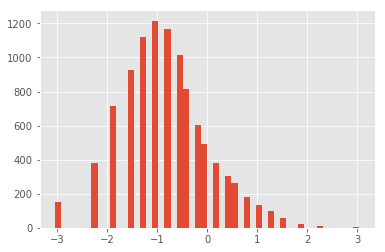

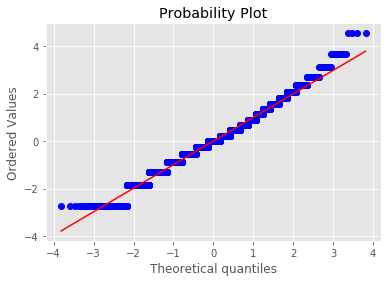

In [40]:
logit_video_title_length = series_tologit(df["video_title_length"])
series_probplot(logit_video_title_length.dropna())

Then we calculate the R² score for video title length. This score shows there are some correlation between total view counts and video title length, but the correlation is quite weak.

In [41]:
rfr_per_feature(logit_video_title_length, logit_video_viewcount, name="video title length")

(0.044999999999999998, 'video title length')


### Video Definition (Higher resolution/lower resolution)

In this part, we will analyze whether the video definition will affect total view count of the video. We process the data and get dummies of video definition. After that, we plot the relationship of video definition and video view count.

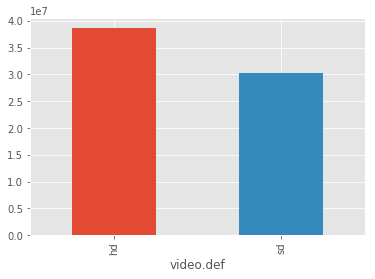

In [42]:
df.groupby('video.def')['video.viewCount'].mean().plot('bar')
plt.show()

In [43]:
df_videodef = pd.get_dummies(df["video.def"])

Then we calculate R² score for video definition. The score shows the relationship between video definition and video view count is weak.

In [44]:
rfr_per_feature(df_videodef, logit_video_viewcount, name="video definition")

(0.029000000000000001, 'video definition')


### Number of Tags in Title and Description

In this part, we will analyze whether including key words, such as tags in video title and description will increase total view count of the video. We first start by processing the data and calculate the number of tags used in title and descriptions.

In [45]:
"""
This function takes in list of video tags, notated as tags.
Also it takes in a target, the target can either be the title or description of the video.
It returns the count of the number of tags in video title/description.
"""

def tag_in_target(tags, target):
    count = 0
    for tag in tags:
        if tag.lower() in target.lower():
            count = count + 1
        else:
            continue
    return count

In [46]:
import ast

no_tags_in_title_list = []
no_tags_in_desc_list = []

for idx, row in df.iterrows():
    tags = row['video.tags']
    tags = ast.literal_eval(tags)
    title = row['snippet.title']
    desc = row['snippet.description']
    no_tags_in_title_list.append(tag_in_target(tags, title))
    no_tags_in_desc_list.append(tag_in_target(tags, desc))
df['no_tags_in_title'] = no_tags_in_title_list
df['no_tags_in_desc'] = no_tags_in_desc_list

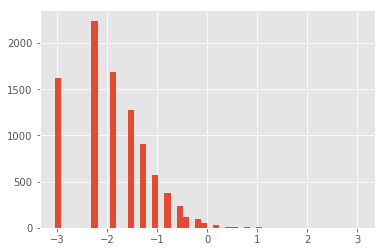

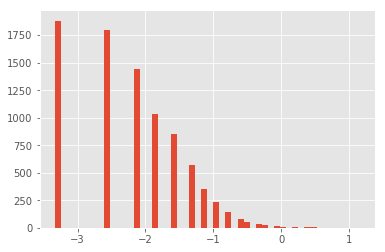

In [47]:
logit_tags_in_title = series_tologit(df['no_tags_in_title'])
logit_tags_in_desc = series_tologit(df['no_tags_in_desc'])

The R² score shows the use of tag words in title and descriptions will not reflect the total view count of the videos.

In [48]:
rfr_per_feature(logit_tags_in_title, logit_video_viewcount, name="no of tags in title")
rfr_per_feature(logit_tags_in_desc, logit_video_viewcount, name="no of tags in desc")

(0.012, 'no of tags in title')
(0.0030000000000000001, 'no of tags in desc')


### Number of http links in description

Here we will analyze whether the number of http links in description will affect total view count of the video. We first process the data and count the number of http links in description. After that, we create the logit representation for this feature.

In [49]:
df["http_in_descp"] = df["snippet.description"].apply(lambda x: x.count("://"))

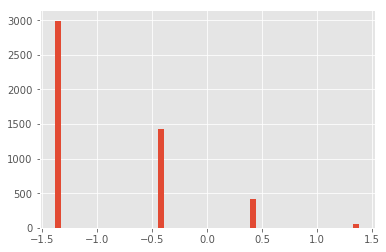

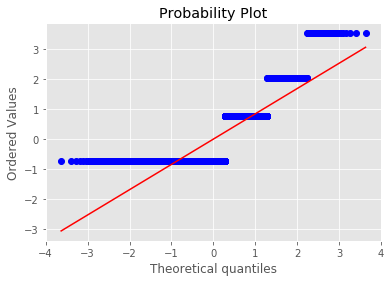

In [50]:
logit_http_in_descp = series_tologit(df["http_in_descp"])
series_probplot(logit_http_in_descp.dropna())

The R² score shows this feature doesn't have much relationship with video view count.

In [51]:
rfr_per_feature(logit_http_in_descp, logit_video_viewcount, name="number of http links in description")

(0.0030000000000000001, 'number of http links in description')


<a id="section_Three"></a>
# Feature Selection

After evaluating each feature using RandomForestRegressor, we can see from the R² scores some features are more likely to be related to YouTube video popularity. However, different features may have effects on each other, so we cannot use only one feature to describe YouTube video popularity. In this section, we will take multiple features into consideration and select several features that can be used to predict YouTube video popularity.

In [52]:
col_list = [logit_channel_subscribe, logit_channel_viewcount, logit_channel_commentcount, 
            logit_video_duration, logit_video_days_old, logit_channel_videocount,
            logit_video_title_length, logit_http_in_descp, logit_tags_in_title,
            logit_tags_in_desc, categoryID, df_videodef, df_tfidf, logit_video_viewcount]

new_df = pd.concat(col_list, axis=1)
new_df = new_df.dropna()
target = new_df['video.viewCount']
features_array = new_df.drop(['video.viewCount'], axis=1)
print(features_array.head(5))
names = features_array.columns.values
features_array = np.array(features_array)
target = np.array(target)

    channel.subscribe  channel.viewcount  channel.commentcount  \
4           -3.142453          -2.825046             -6.604039   
5           11.651608          -0.075228             -1.325453   
10          -2.552912          -2.099709             -4.689085   
14          -4.256366          -5.171413            -13.442724   
15          -2.595119          -2.204314            -10.041485   

    video.lengthInSec  no_of_days_published  channel.videocount  \
4           -6.047430              1.456621          -10.397139   
5           -4.706112             -7.773805           -4.306132   
10          -4.410146             -7.773805           -3.771139   
14          -3.443111             -3.510680           -8.057454   
15          -5.005250             -7.773805           -4.850567   

    video_title_length  http_in_descp  no_tags_in_title  no_tags_in_desc  \
4            -0.762140      -0.405465         -0.980829        -1.832581   
5            -1.845827       0.405465         -3

After basic processing of the features, we will try three different regressors, RandomForestRegressor, GradientBoostingRegressor, and AdaBoostRegressor, on all the features. The higher the R² score is, the more accurate the regressor is. So, after plenty of experiments, we choose the one with highest R² score (0.6), which is GradientBoostingRegressor.

Compared to RandomForestRegressor and AdaBoostRegressor, GradientBoostingRegressor can handle data of mixed types, in this case, we have two different types of data (continuous and categorical), in addition, this regressor is robust to outliers in output space.

In [54]:
rf = RandomForestRegressor(random_state=1, n_estimators=20, max_depth=4)
scores = []
score = cross_val_score(rf, features_array, target, scoring='r2', cv=ShuffleSplit(len(features_array), 10, .1))
scores.append((round(np.mean(score), 3), "all features included, model: random forest regression"))
print(sorted(scores, reverse=True))

[(0.55200000000000005, 'all features included, model: random forest regression')]


In [55]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor(random_state=1, n_estimators=20, max_depth=4)
scores = []
score = cross_val_score(gbr, features_array, target, scoring='r2', cv=ShuffleSplit(len(features_array), 10, .1))
scores.append((round(np.mean(score), 3), "all features included, model: gradient boosting regression"))
print(sorted(scores, reverse=True))

[(0.60899999999999999, 'all features included, model: gradient boosting regression')]


In [56]:
from sklearn.ensemble import AdaBoostRegressor

abr = AdaBoostRegressor(random_state=1, n_estimators=20)
scores = []
score = cross_val_score(abr, features_array, target, scoring='r2', cv=ShuffleSplit(len(features_array), 10, .1))
scores.append((round(np.mean(score), 3), "all features included, model: ada boost regression"))
print(sorted(scores, reverse=True))

[(0.58399999999999996, 'all features included, model: ada boost regression')]


After determining the regressor, we’ll perform four tests for feature selection.

Test 1: Remove categoryID, df_videodef, df_tfidf from col_list and call feature_importances function on the regressor. The results show that the five most important features are no_of_days_published, channel.viewcount, channel.videocount, video.lengthInSec, and channel.subscribe.

In [57]:
"""
The sklearn feature_importances_ function works best for real value features, so we exclude three
discontinuous features: categoryID, df_videodef, df_tfidf in our analysis.
"""

col_list = [logit_channel_subscribe, logit_channel_viewcount, logit_channel_commentcount, 
            logit_video_duration, logit_video_days_old, logit_channel_videocount,
            logit_video_title_length, logit_http_in_descp, logit_tags_in_title,
            logit_tags_in_desc, logit_video_viewcount]

new_df = pd.concat(col_list, axis=1)
new_df = new_df.dropna()
target = new_df['video.viewCount']
features_array = new_df.drop(['video.viewCount'], axis=1)
print(features_array.head(5))
names = features_array.columns.values
features_array = np.array(features_array)
target = np.array(target)

    channel.subscribe  channel.viewcount  channel.commentcount  \
4           -3.142453          -2.825046             -6.604039   
5           11.651608          -0.075228             -1.325453   
10          -2.552912          -2.099709             -4.689085   
14          -4.256366          -5.171413            -13.442724   
15          -2.595119          -2.204314            -10.041485   

    video.lengthInSec  no_of_days_published  channel.videocount  \
4           -6.047430              1.456621          -10.397139   
5           -4.706112             -7.773805           -4.306132   
10          -4.410146             -7.773805           -3.771139   
14          -3.443111             -3.510680           -8.057454   
15          -5.005250             -7.773805           -4.850567   

    video_title_length  http_in_descp  no_tags_in_title  no_tags_in_desc  
4            -0.762140      -0.405465         -0.980829        -1.832581  
5            -1.845827       0.405465         -3.0

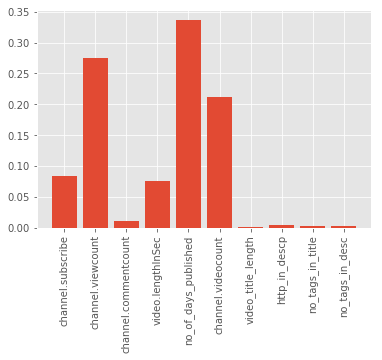

In [63]:
gbr = GradientBoostingRegressor(random_state=1, n_estimators=20, max_depth=4)
scores = []

gbr.fit(features_array, target)
importance = gbr.feature_importances_

labels = list(new_df.columns.values)
y = importance
dummy_x = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
plt.bar(dummy_x, y, align='center')
plt.xticks(dummy_x, labels[:-1])
plt.xticks(rotation=90)
plt.show()

Test 2: Exclude the five important features obtained from Test 1. After removing the five important features, the R² score decrease from 0.6 to 0.26, which means the removed features are very important for describing video popularity.

In [64]:
col_list = [logit_channel_commentcount, logit_video_title_length, logit_http_in_descp, logit_tags_in_title,
            logit_tags_in_desc, categoryID, df_videodef, df_tfidf, logit_video_viewcount]

test_df = pd.concat(col_list, axis=1)
test_df = test_df.dropna()
target_test = test_df['video.viewCount']
features_test_array = test_df.drop(['video.viewCount'], axis=1)
print(features_test_array.head(5))
names = features_test_array.columns.values
features_test_array = np.array(features_test_array)
target_test = np.array(target_test)

    channel.commentcount  video_title_length  http_in_descp  no_tags_in_title  \
4              -6.604039           -0.762140      -0.405465         -0.980829   
5              -1.325453           -1.845827       0.405465         -3.044522   
10             -4.689085           -0.182322      -1.386294         -1.845827   
14            -13.442724           -0.367725      -1.386294         -3.044522   
15            -10.041485           -0.559616      -1.386294         -2.302585   

    no_tags_in_desc  categoryID.1  categoryID.2  categoryID.10  categoryID.15  \
4         -1.832581           1.0           0.0            0.0            0.0   
5         -3.332205           0.0           0.0            0.0            0.0   
10        -3.332205           0.0           0.0            0.0            0.0   
14        -3.332205           1.0           0.0            0.0            0.0   
15        -1.343735           0.0           0.0            0.0            0.0   

    categoryID.17  ...   6

In [65]:
rf = GradientBoostingRegressor(random_state=1, n_estimators=20, max_depth=4)
scores = []
score = cross_val_score(rf, features_test_array, target_test, 
                        scoring='r2', cv=ShuffleSplit(len(features_test_array), 10, .1))
scores.append((round(np.mean(score), 3), "all important features excluded"))
print(sorted(scores, reverse=True))

[(0.26700000000000002, 'all important features excluded')]


Test 3: Only retain five important features in col_list. The R² score is 0.70, which is higher than 0.6, also supports the conclusion in Test 1.

In [66]:
col_list = [logit_channel_subscribe, logit_channel_viewcount, logit_video_duration,
            logit_video_days_old, logit_channel_videocount, logit_video_viewcount]

test_df = pd.concat(col_list, axis=1)
test_df = test_df.dropna()
target_test = test_df['video.viewCount']
features_test_array = test_df.drop(['video.viewCount'], axis=1)
print(features_test_array.head(5))
names = features_test_array.columns.values
features_test_array = np.array(features_test_array)
target_test = np.array(target_test)

   channel.subscribe  channel.viewcount  video.lengthInSec  \
1          -4.535904          -3.819152          -6.648553   
4          -3.142453          -2.825046          -6.047430   
5          11.651608          -0.075228          -4.706112   
7          -3.297643          -2.834816          -5.937536   
8          -3.521350          -4.703843          -5.884188   

   no_of_days_published  channel.videocount  
1             -8.467162           -5.395430  
4              1.456621          -10.397139  
5             -7.773805           -4.306132  
7              0.383440           -5.596643  
8             -7.773805           -7.059652  


In [67]:
rf = GradientBoostingRegressor(random_state=1, n_estimators=20, max_depth=4)
scores = []
score = cross_val_score(rf, features_test_array, target_test, 
                        scoring='r2', cv=ShuffleSplit(len(features_test_array), 10, .1))
scores.append((round(np.mean(score), 3), "five important features included"))
print(sorted(scores, reverse=True))

[(0.70099999999999996, 'five important features included')]


Test 4: We exclude the three discontinuous (categorical) features in col_list. The R² score is 0.59 (close to 0.6), which means these three removed features are not important in describing video popularity.

In [70]:
col_list = [logit_channel_subscribe, logit_channel_viewcount, logit_channel_commentcount, 
            logit_video_duration, logit_video_days_old, logit_channel_videocount,
            logit_video_title_length, logit_http_in_descp, logit_tags_in_title,
            logit_tags_in_desc, logit_video_viewcount]

incontinuous_df = pd.concat(col_list, axis=1)
incontinuous_df = incontinuous_df.dropna()
target_test = incontinuous_df['video.viewCount']
features_test_array = incontinuous_df.drop(['video.viewCount'], axis=1)
print(features_test_array.head(5))
names = features_test_array.columns.values
features_test_array = np.array(features_test_array)
target_test = np.array(target_test)

    channel.subscribe  channel.viewcount  channel.commentcount  \
4           -3.142453          -2.825046             -6.604039   
5           11.651608          -0.075228             -1.325453   
10          -2.552912          -2.099709             -4.689085   
14          -4.256366          -5.171413            -13.442724   
15          -2.595119          -2.204314            -10.041485   

    video.lengthInSec  no_of_days_published  channel.videocount  \
4           -6.047430              1.456621          -10.397139   
5           -4.706112             -7.773805           -4.306132   
10          -4.410146             -7.773805           -3.771139   
14          -3.443111             -3.510680           -8.057454   
15          -5.005250             -7.773805           -4.850567   

    video_title_length  http_in_descp  no_tags_in_title  no_tags_in_desc  
4            -0.762140      -0.405465         -0.980829        -1.832581  
5            -1.845827       0.405465         -3.0

In [71]:
rf = GradientBoostingRegressor(random_state=1, n_estimators=20, max_depth=4)
scores = []
score = cross_val_score(rf, features_test_array, target_test, 
                        scoring='r2', cv=ShuffleSplit(len(features_test_array), 10, .1))
scores.append((round(np.mean(score), 3), "only three incontinuous features included"))
print(sorted(scores, reverse=True))

[(0.59799999999999998, 'only three incontinuous features included')]


As a result, the five features we choose are no_of_days_published, channel.viewcount, channel.videocount, video.lengthInSec, and channel.subscribe. The four tests above prove the importance of the five features on describing video popularity.

<a id="section_Four"></a>
# Prediction Results

Here, we will use the five identified features to predict video popularity using the Gradient Boosting Regression model. First, we start from building up the features for our prediction.

In [74]:
col_list = [logit_channel_subscribe, logit_channel_viewcount, logit_video_duration,
            logit_video_days_old, logit_channel_videocount, logit_video_viewcount]

predict_df = pd.concat(col_list, axis=1)
predict_df = predict_df.dropna()
X = predict_df.drop(['video.viewCount'], axis=1).values
print("feature list")
print(X)
y = predict_df['video.viewCount'].values
print("target list")
print(y)

feature list
[[ -4.53590386  -3.8191524   -6.64855268  -8.46716226  -5.39543028]
 [ -3.14245307  -2.82504642  -6.04742984   1.45662116 -10.39713904]
 [ 11.65160848  -0.0752279   -4.70611164  -7.77380479  -4.30613183]
 ..., 
 [ -4.06040138  -4.13079279  -5.73478499  -0.8938837   -8.03363553]
 [ -0.96909452  -0.93810111  -4.69483676  -0.57583862  -2.83882572]
 [ -7.51500763  -9.61149922  -2.48576378  -3.40424285  -8.15883683]]
target list
[-9.74282463 -1.03999476 -7.43517162 ..., -5.49102663 -6.1503098
 -8.86864873]


Next, we split our data into training dataset, cross validation dataset and test dataset to evaluate the model's prediction accuracy.

In [75]:
from sklearn.model_selection import train_test_split
X_, X_test, y_, y_test = train_test_split(X, y, test_size = 0.1, random_state=0)
X_train, X_cv, y_train, y_cv = train_test_split(X_, y_, test_size = 0.1, random_state=0)
clf = GradientBoostingRegressor(random_state=1, n_estimators=20, max_depth=4)
clf.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=4, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=20, presort='auto', random_state=1,
             subsample=1.0, verbose=0, warm_start=False)

The mean square error for each dataset is listed as following. We compare the MSE with the baseline MSE, which simply use the mean of the video view count as an approximate estimation. From the following comparison, our model yields a consistently lower MSE than the baseline MSE in all cases. This shows our model is effective in predicting video popularity.

In [76]:
print("Training MSE: ", np.mean((clf.predict(X_train) - y_train)**2))
print("Baseline training MSE: ", np.mean((np.mean(y_train) - y_train)**2))

Training MSE:  2.09164558006
Baseline training MSE:  7.42120955181


In [77]:
print("CV MSE: ", np.mean((clf.predict(X_cv) - y_cv)**2))
print("Baseline CV MSE: ", np.mean((np.mean(y_train) - y_cv)**2))

CV MSE:  2.45423097727
Baseline CV MSE:  7.4584312167


In [78]:
print("Test MSE: ", np.mean((clf.predict(X_test) - y_test)**2))
print("Baseline Test MSE: ", np.mean((np.mean(y_train) - y_test)**2))

Test MSE:  2.21273776438
Baseline Test MSE:  7.61472100165


<a id="section_Five"></a>
# Conclusion

In this project, we collect video information from YouTube API and use these data to analyze what features contribute most to video popularity. We analyze each feature one by one, which gives us an insight of each feature's contribution. Furthermore, we select GradientBoostingRegressor to identify what features are important to video popularity, and four tests are performed to prove that no_of_days_published, channel.viewcount, channel.videocount, video.lengthInSec, and channel.subscribe are the five most important features. At last, we make predictions using the five identified features and evaluate the results using MSE. And the results show that the model we choose, the features we identify are pretty effective in predicting video popularity.

<a id="section_Six"></a>
# References

[YouTube Data API v3](https://developers.google.com/youtube/v3/getting-started) <br>
[R² score](http://scikit-learn.org/stable/modules/model_evaluation.html#r2-score) <br>
[Random Forest](https://towardsdatascience.com/the-random-forest-algorithm-d457d499ffcd) <br>
[YouTube-Like-predictor](https://github.com/ayush1997/YouTube-Like-predictor) <br>
[Selecting good features](http://blog.datadive.net/selecting-good-features-part-i-univariate-selection/)